In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import log_loss
import shap

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

## 1. Load the Data

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [4]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,start_date,home_id,home_team,home_conference,home_points,home_pregame_elo,away_id,away_team,away_conference,away_points,away_pregame_elo,home_division,away_division
0,332412309,2013,1,regular,True,False,3696.0,2013-08-29 22:00:00+00:00,2309,Kent State,Mid-American,17.0,1530.0,2335,Liberty,Big South,10.0,1467.0,fbs,fcs
1,332412579,2013,1,regular,True,False,3994.0,2013-08-29 22:00:00+00:00,2579,South Carolina,SEC,27.0,1759.0,153,North Carolina,ACC,10.0,1638.0,fbs,fbs
2,332410154,2013,1,regular,True,False,3630.0,2013-08-29 22:30:00+00:00,154,Wake Forest,ACC,31.0,NaN,2506,Presbyterian,Big South,7.0,NaN,fbs,fcs
3,332410084,2013,1,regular,True,False,3830.0,2013-08-29 23:00:00+00:00,84,Indiana,Big Ten,73.0,NaN,282,Indiana State,MVFC,35.0,NaN,fbs,fcs
4,332412413,2013,1,regular,True,False,3774.0,2013-08-29 23:00:00+00:00,2413,Morehead State,Pioneer,10.0,NaN,95,Pikeville,None,13.0,NaN,fcs,None


In [5]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in YEARS:
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = df_games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            df_tmp = pd.DataFrame([val.to_dict() for val in data])
            if df_tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            df_tmp.columns = convert_to_snake_case(df_tmp.columns)

            df_tmp['clock_minutes'] = df_tmp['clock'].apply(lambda x: x['minutes'])
            df_tmp['clock_seconds'] = df_tmp['clock'].apply(lambda x: x['seconds'])
            df_tmp.drop(columns=['clock'], inplace=True)

            df_tmp = df_tmp[cols]
            season_dfs.append(df_tmp)
        
        df_season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        df_season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, df_tmp

    all_dfs.append(df_season_plays)

    del df_season_plays
    
df_plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_plays.head()

Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


,season,week,season_type,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,2013,1,regular,332430120038,33243012007,332430120,7,1,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,40,60,1,10,2,False,Pass Completion,C.J. Brown pass complete to Dave Stinebaugh fo...,-0.679984,3,31
1,2013,1,regular,332430120044,33243012007,332430120,7,4,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,53,47,1,10,2,False,Rush,Brandon Ross rush for 2 yards to the FlaIn 45.,-0.583582,2,9
2,2013,1,regular,332430120047,33243012007,332430120,7,6,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,57,43,3,6,10,False,Pass Completion,C.J. Brown pass complete to Stefon Diggs for 1...,1.925720,1,9
3,2013,1,regular,332430120042,33243012007,332430120,7,3,Maryland,ACC,13,Florida International,Maryland,Florida International,Conference USA,3,1,2.0,3.0,49,51,3,1,4,False,Rush,C.J. Brown rush for 4 yards to the FlaIn 47 fo...,1.200877,2,44
4,2013,1,regular,332430120053,33243012007,332430120,7,10,Maryland,ACC,20,Florida International,Maryland,Florida International,Conference USA,3,2,2.0,3.0,35,65,-1,-1,0,False,Kickoff,Brad Craddock kickoff for 65 yards for a touch...,NaN,14,54


In [6]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
df_elos = pd.concat(elos, ignore_index=True).reset_index(drop=True)
df_elos = df_elos.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
df_elos.head()

,season,week,season_type,team_id,team,division,elo
0,2013,1,regular,2,Auburn,fbs,2264.753528
1,2013,2,regular,2,Auburn,fbs,2254.767777
2,2013,3,regular,2,Auburn,fbs,2303.322874
3,2013,4,regular,2,Auburn,fbs,2344.906060
4,2013,6,regular,2,Auburn,fbs,2338.580248


In [7]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,332412579,2013,1,regular,2013-08-29 22:00:00+00:00,False,South Carolina,SEC,North Carolina,ACC,3994,Williams-Brice Stadium,93.9,71.8,49.0,0.0,0,340.0,0.0,1011.7,NaN,None
1,332410254,2013,1,regular,2013-08-30 00:00:00+00:00,False,Utah,Pac-12,Utah State,Mountain West,587,Rice-Eccles Stadium,95.0,46.2,19.0,0.0,0,320.0,0.0,1012.6,NaN,None
2,332422247,2013,1,regular,2013-08-30 23:00:00+00:00,False,Georgia State,Sun Belt,Samford,Southern,3495,Georgia Dome,82.9,73.8,74.0,0.0,0,40.0,0.0,1012.9,NaN,None
3,332430059,2013,1,regular,2013-08-31 16:00:00+00:00,False,Georgia Tech,ACC,Elon,Southern,721,Bobby Dodd Stadium,84.0,72.0,67.0,0.0,0,250.0,0.0,1014.0,NaN,None
4,332430277,2013,1,regular,2013-08-31 16:00:00+00:00,False,West Virginia,Big 12,William & Mary,CAA,3842,Milan Puskar Stadium,79.0,67.1,67.0,0.0,0,230.0,0.0,1012.0,NaN,None


In [8]:
# Load ppa data
all_dfs = []

ppa_dir = join(DATA_DIR, 'ppa')
if not os.path.exists(ppa_dir):
    os.makedirs(ppa_dir)

#NOTE: the custom date range with an extra year prior to 2013 for the optmization of 2013's season
for year in range(2012, 2025):
    season_file_path = join(ppa_dir, f'{year}.parquet')
    df_season_ppa = None
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        df_season_ppa = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks ppa data for {year} from CFBD API')

        print(f'Fetching {year} ppa data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.MetricsApi(api_client)
            data = api_instance.get_predicted_points_added_by_game(
                year=year, 
                exclude_garbage_time=True
            )
        df_season_ppa = pd.DataFrame([val.to_dict() for val in data])
        if df_season_ppa.empty:
            print(f'No ppa data for {year}')
            continue
        df_season_ppa.columns = convert_to_snake_case(df_season_ppa.columns)

        df_season_ppa = (
            df_season_ppa.assign(
                offense_ppa = df_season_ppa['offense'].apply(lambda x: x['overall']),
                defense_ppa = df_season_ppa['defense'].apply(lambda x: x['overall'])
            )
            .drop(columns=['offense', 'defense'])
        )

        df_season_ppa['season_type'] = df_season_ppa['season_type'].apply(lambda x: x.value)

        df_season_ppa.to_parquet(season_file_path)
        print(f'Saved ppa data for {year} to {season_file_path}')

    all_dfs.append(df_season_ppa)

    del df_season_ppa
    
df_ppa = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)

# only keep regular and postseason
df_ppa = df_ppa[df_ppa['season_type'].isin(['regular', 'postseason'])].reset_index(drop=True)
df_ppa.head()

Reading ../data/ppa/2012.parquet from cached data
Reading ../data/ppa/2013.parquet from cached data
Reading ../data/ppa/2014.parquet from cached data
Reading ../data/ppa/2015.parquet from cached data
Reading ../data/ppa/2016.parquet from cached data
Reading ../data/ppa/2017.parquet from cached data
Reading ../data/ppa/2018.parquet from cached data
Reading ../data/ppa/2019.parquet from cached data
Reading ../data/ppa/2020.parquet from cached data
Reading ../data/ppa/2021.parquet from cached data
Reading ../data/ppa/2022.parquet from cached data
Reading ../data/ppa/2023.parquet from cached data
Reading ../data/ppa/2024.parquet from cached data


,game_id,season,week,season_type,team,conference,opponent,offense_ppa,defense_ppa
0,322452005,2012,1,regular,Air Force,Mountain West,Idaho State,0.32,0.16
1,322432006,2012,1,regular,Akron,Mid-American,UCF,-0.17,0.16
2,322450333,2012,1,regular,Alabama,SEC,Michigan,0.27,0.03
3,322450012,2012,1,regular,Arizona,Pac-12,Toledo,0.21,-0.03
4,322430009,2012,1,regular,Arizona State,Pac-12,Northern Arizona,0.48,-0.24


## 2. Join and Filter the Data

In [9]:
valid_plays = ['Pass Incompletion', 'Pass Completion', 'Rush',
       'Pass Interception', 'Safety', 'Sack', 'Pass Interception Return',
       'Pass Reception', 'Passing Touchdown', 'Rushing Touchdown',
       'Fumble Recovery (Opponent)', 'Fumble Recovery (Own)',
       'Fumble Return Touchdown', 
       'Interception Return Touchdown', 
       'Defensive 2pt Conversion',
       'Pass', 'Interception', 'Uncategorized']

fourth_down_plays = (
    df_plays
    .query('down==4 and play_type in @valid_plays')
    .reset_index(drop=True)
    .assign(
        rush=lambda x: np.where(x['play_text'].str.contains('rush', case=False) |
                                x['play_text'].str.contains('run', case=False) |
                                x['play_text'].str.contains('scramble', case=False) |
                                (x['play_type'] == 'Rush'), 1, 0),
        sack=lambda x: np.where((x['play_type'].str.contains('sack', case=False) | 
                                 x['play_text'].str.contains('sack', case=False)), 1, 0),
        pass_=lambda x: np.where(x['play_type'].str.contains('pass', case=False) |
                                 x['play_text'].str.contains('pass', case=False), 1, 0),
        interception=lambda x: np.where(x['play_text'].str.contains('intercept', case=False), 1, 0),
        kick=lambda x: np.where(x['play_text'].str.contains('kick', case=False), 1, 0),
        punt=lambda x: np.where(x['play_text'].str.contains('punt', case=False), 1, 0),
        field_goal=lambda x: np.where(x['play_text'].str.contains('field goal', case=False) |
                                      x['play_text'].str.contains('fg', case=False), 1, 0),
        kneel=lambda x: np.where(x['play_text'].str.contains('knee', case=False), 1, 0),
        penalty=lambda x: np.where(x['play_text'].str.contains('penalty', case=False), 1, 0),
        illegal_shift=lambda x: np.where(x['play_text'].str.contains('illegal shift', case=False), 1, 0),
        illegal_formation=lambda x: np.where(x['play_text'].str.contains('illegal formation', case=False), 1, 0),
        false_start=lambda x: np.where(x['play_text'].str.contains('false start', case=False), 1, 0),
        delay_of_game=lambda x: np.where(x['play_text'].str.contains('delay of game', case=False), 1, 0),
    )
    .query('punt==0 and kick==0 and field_goal==0 and kneel==0')
    .drop(columns=['punt','kick','field_goal','kneel'])
    .query('penalty==0 and illegal_shift==0 and illegal_formation==0 and false_start==0 and delay_of_game==0')
    .drop(columns=['penalty','illegal_shift','illegal_formation','false_start','delay_of_game'])
    # drop the plays not categorized as pass, rush, sack, or interception -> not enough context around play type
    .query('~(pass_==0 and rush==0 and sack==0 and interception==0)')
    .reset_index(drop=True)
)

In [10]:
(
    fourth_down_plays.rush.value_counts(normalize=True), 
    fourth_down_plays.sack.value_counts(normalize=True),
    fourth_down_plays.pass_.value_counts(normalize=True),
    fourth_down_plays.interception.value_counts(normalize=True)
)

(rush
 0    0.508208
 1    0.491792
 Name: proportion, dtype: float64,
 sack
 0    0.960412
 1    0.039588
 Name: proportion, dtype: float64,
 pass_
 0    0.526498
 1    0.473502
 Name: proportion, dtype: float64,
 interception
 0    0.976643
 1    0.023357
 Name: proportion, dtype: float64)

In [11]:
fourth_down_plays['first_down'] = np.where(
    (fourth_down_plays['yards_gained'] >= fourth_down_plays['distance']) &
    (fourth_down_plays['interception'] == 0) &
    (fourth_down_plays['sack'] == 0)
    , 1
    , 0
)

In [12]:
# Merge games and plays data
game_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id', 
        'home_team','home_id','home_points', 
        'away_team','away_id', 'away_points']

id_cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number','season', 'week']

play_cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 
             'offense', 'offense_conference', 'offense_score', 
             'defense', 'defense_conference', 'defense_score', 
             'home', 'away',
             'period', 'offense_timeouts', 'defense_timeouts', 
             'yardline', 'yards_to_goal', 'down', 'distance',
             'yards_gained', 'play_type', 'play_text',
             'clock_minutes', 'clock_seconds', 'first_down']

elo_cols = ['season', 'week', 'division', 'team_id', 'elo']

weather_cols = ['id', 'game_indoors', 'temperature', 
       'precipitation', 'wind_speed', ]

df = (
    df_games[game_cols].merge(fourth_down_plays[play_cols], left_on='id', right_on='game_id', suffixes=('_game', ''))
    .drop(columns=['id_game'])
    .rename(columns={'id': 'play_id'})
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'home_id', 'division': 'home_division', 'elo': 'home_pregame_elo'}),
        on=['season', 'week', 'home_id'],
        how='left'
    )
    .merge(
        df_elos[elo_cols].rename(columns={'team_id': 'away_id', 'division': 'away_division', 'elo': 'away_pregame_elo'}),
        on=['season', 'week', 'away_id'],
        how='left'
    )
    .merge(
        df_weather[weather_cols].rename(columns={'id': 'game_id'}),
        on=['game_id'],
        how='left',
    )
)
df = (
    df
    .assign(
        game_indoors = df.game_indoors.fillna(False),
        temperature = np.where(df.game_indoors, 70, df.temperature.fillna(int(df.temperature.mean()))),
        wind_speed = np.where(df.game_indoors, 0, df.wind_speed.fillna(int(df.wind_speed.mean()))),
        precipitation = np.where(df.game_indoors, 0, df.precipitation.fillna(int(df.precipitation.mean())))
    )
)
df = df[id_cols + [c for c in df.columns if c not in id_cols]]

# move first_down to the end
df = df[[c for c in df.columns if c != 'first_down'] + ['first_down']]
df.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_72036/3090270967.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_indoors = df.game_indoors.fillna(False),


,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,defense_conference,defense_score,home,away,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,play_type,play_text,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,game_indoors,temperature,precipitation,wind_speed,first_down
0,332412309,33241230920,332412309178,20,6,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,17,Liberty,Big South,10,Kent State,Liberty,4,0.0,0.0,33,67,4,17,-3,Rush,Team rush for a loss of 3 yards to the KntSt 30.,0,3,fbs,1952.975932,fcs,1551.990878,False,82.0,0.0,3.4,0
1,332412309,33241230905,332412309035,5,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Big South,0,Kent State,Liberty,1,2.0,3.0,54,46,4,1,4,Rush,Trayion Durham rush for 4 yards to the Liber 4...,2,6,fbs,1952.975932,fcs,1551.990878,False,82.0,0.0,3.4,1
2,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Big South,10,Kent State,Liberty,3,2.0,2.0,64,36,4,3,-3,Rush,Colin Reardon rush for a loss of 3 yards to th...,4,21,fbs,1952.975932,fcs,1551.990878,False,82.0,0.0,3.4,0
3,332412309,33241230919,332412309172,19,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Liberty,Big South,10,Kent State,Mid-American,17,Kent State,Liberty,4,1.0,1.0,40,40,4,5,0,Pass Incompletion,Josh Woodrum pass incomplete to Darrin Peterso...,1,35,fbs,1952.975932,fcs,1551.990878,False,82.0,0.0,3.4,0
4,332412579,33241257919,332412579208,19,5,2013,1,regular,True,False,3994.0,South Carolina,2579,27.0,North Carolina,153,10.0,South Carolina,SEC,27,North Carolina,ACC,10,South Carolina,North Carolina,4,3.0,2.0,55,45,4,1,0,Rush,Brandon Wilds rush for no gain to the NCaro 45.,3,32,fbs,3033.615891,fbs,2473.889755,False,93.9,0.0,0.0,0


In [13]:
# Filter out overtime plays
df = df.query('0 < period <= 4')

# Game must be completed
df = df.query('completed == True')

In [14]:
df.isna().sum()

game_id                 0
drive_id                0
play_id                 0
drive_number            0
play_number             0
season                  0
week                    0
season_type             0
completed               0
neutral_site            0
venue_id              105
home_team               0
home_id                 0
home_points             0
away_team               0
away_id                 0
away_points             0
offense                 0
offense_conference    115
offense_score           0
defense                 0
defense_conference     79
defense_score           0
home                    0
away                    0
period                  0
offense_timeouts        0
defense_timeouts        0
yardline                0
yards_to_goal           0
down                    0
distance                0
yards_gained            0
play_type               0
play_text              89
clock_minutes           0
clock_seconds           0
home_division           0
home_pregame

## 3. Feature Engineering

In [15]:
df = df.assign(
    pct_game_played = (((df['period'] - 1) * 15 * 60) + ((15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))) / (4 * 15 * 60),
    game_seconds_remaining = ((4 * 15 * 60) - ((df['period'] - 1) * 15 * 60 + (15 * 60) - (df['clock_minutes'] * 60 + df['clock_seconds']))),
    score_diff = df['offense_score'] - df['defense_score'],
    is_home_team = np.select([df.neutral_site, df.offense == df.home], [0, 1], default=-1),
    pregame_elo_diff = np.where(df['offense'] == df['home'], df['home_pregame_elo'] - df['away_pregame_elo'], df['away_pregame_elo'] - df['home_pregame_elo']),
    pregame_offense_elo = np.where(df['offense'] == df['home'], df['home_pregame_elo'], df['away_pregame_elo']),
    pregame_defense_elo = np.where(df['offense'] == df['home'], df['away_pregame_elo'], df['home_pregame_elo']),
    offense_division = np.where(df['offense'] == df['home'], df['home_division'], df['away_division']),
    defense_division = np.where(df['offense'] == df['home'], df['away_division'], df['home_division']),
).assign(
    diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['game_seconds_remaining']) / 3600),
)

df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,completed,neutral_site,venue_id,home_team,home_id,home_points,away_team,away_id,away_points,offense,offense_conference,offense_score,defense,defense_conference,defense_score,home,away,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,play_type,play_text,clock_minutes,clock_seconds,home_division,home_pregame_elo,away_division,away_pregame_elo,game_indoors,temperature,precipitation,wind_speed,first_down,pct_game_played,game_seconds_remaining,score_diff,is_home_team,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_division,defense_division,diff_time_ratio
0,332412309,33241230920,332412309178,20,6,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,17,Liberty,Big South,10,Kent State,Liberty,4,0.0,0.0,33,67,4,17,-3,Rush,Team rush for a loss of 3 yards to the KntSt 30.,0,3,fbs,1952.975932,fcs,1551.990878,False,82.0,0.0,3.4,0,0.999167,3,7,1,400.985054,1952.975932,1551.990878,fbs,fcs,380.915214
1,332412309,33241230905,332412309035,5,5,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Big South,0,Kent State,Liberty,1,2.0,3.0,54,46,4,1,4,Rush,Trayion Durham rush for 4 yards to the Liber 4...,2,6,fbs,1952.975932,fcs,1551.990878,False,82.0,0.0,3.4,1,0.215000,2826,7,1,400.985054,1952.975932,1551.990878,fbs,fcs,16.542125
2,332412309,33241230914,332412309118,14,10,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Kent State,Mid-American,7,Liberty,Big South,10,Kent State,Liberty,3,2.0,2.0,64,36,4,3,-3,Rush,Colin Reardon rush for a loss of 3 yards to th...,4,21,fbs,1952.975932,fcs,1551.990878,False,82.0,0.0,3.4,0,0.677500,1161,-3,1,400.985054,1952.975932,1551.990878,fbs,fcs,-45.087827
3,332412309,33241230919,332412309172,19,9,2013,1,regular,True,False,3696.0,Kent State,2309,17.0,Liberty,2335,10.0,Liberty,Big South,10,Kent State,Mid-American,17,Kent State,Liberty,4,1.0,1.0,40,40,4,5,0,Pass Incompletion,Josh Woodrum pass incomplete to Darrin Peterso...,1,35,fbs,1952.975932,fcs,1551.990878,False,82.0,0.0,3.4,0,0.973611,95,-7,-1,-400.985054,1551.990878,1952.975932,fcs,fbs,-343.901264
4,332412579,33241257919,332412579208,19,5,2013,1,regular,True,False,3994.0,South Carolina,2579,27.0,North Carolina,153,10.0,South Carolina,SEC,27,North Carolina,ACC,10,South Carolina,North Carolina,4,3.0,2.0,55,45,4,1,0,Rush,Brandon Wilds rush for no gain to the NCaro 45.,3,32,fbs,3033.615891,fbs,2473.889755,False,93.9,0.0,0.0,0,0.941111,212,17,1,559.726136,3033.615891,2473.889755,fbs,fbs,733.375456


In [17]:
# FBS offense only
df = df.query('offense_division == "fbs"').reset_index(drop=True)

#### Add Offensive and Defensive Strength variables optimized based off of Offense PPA

In [18]:
from scipy.optimize import minimize

def calculate_team_strengths(season, week, season_type, df_ppa_all, window_size=10):
    """
    Calculate offensive and defensive strengths for teams based on most recent games.
    
    Parameters:
    - season: int, the current season
    - week: int, the current week
    - df_ppa_all: DataFrame containing all historical PPA data
    - window_size: int, number of previous weeks to consider (default=10)
    
    Returns:
    - DataFrame with team, offensive_strength, defensive_strength columns
    """
        # Convert season/week to a numerical value for sorting
    year = season
    df_ppa_all = df_ppa_all.copy()
    if set(df_ppa_all['season_type'].unique().tolist()) != set(['regular', 'postseason']):
        raise ValueError("PPA data must contain both 'regular' and 'postseason' season types")
    df_ppa_all['season_type_indicator'] = df_ppa_all['season_type'].apply(lambda x: 1 if x == 'regular' else 2)
    df_ppa_all['season_week'] = df_ppa_all['season'] * 1000 + df_ppa_all['season_type_indicator'] * 100 + df_ppa_all['week']
    season_type_indicator = 1 if season_type == 'regular' else 2
    target_sw = year * 1000 + season_type_indicator * 100 + week
    
    # Get all games before the target week
    df_prior = df_ppa_all[df_ppa_all['season_week'] < target_sw].copy()
    
    if len(df_prior) == 0:
        raise ValueError(f"No historical data available before season {year} week {week}")
    
    # Sort by season and week (most recent first)
    df_prior = df_prior.sort_values(
        ['season', 'season_type_indicator', 'week'], 
        ascending=[False, False, False]
    )
    
    # Get the most recent window_size weeks of games
    unique_weeks = df_prior[['season','season_type_indicator', 'week']].drop_duplicates()
    recent_weeks = unique_weeks.head(window_size)
    
    # Filter to just these weeks
    df_window = pd.merge(
        left=df_prior, 
        right=recent_weeks, 
        on=['season', 'season_type_indicator', 'week'], 
        how='inner'
    )
    
    if len(df_window) == 0:
        raise ValueError(f"Insufficient data available - found {len(df_prior)} "
                         f"prior games but none in last {window_size} weeks")
    
    # Get all unique teams in the data window
    all_teams = pd.concat([df_window['team'], df_window['opponent']]).unique()
    num_teams = len(all_teams)

    # Create mappings between team names and indices
    team_to_idx = {team: idx for idx, team in enumerate(all_teams)}
    
    # Variables: offensive and defensive strengths for each team
    num_vars = 2 * num_teams
    
    df_window['offense_idx'] = df_window['team'].map(team_to_idx)
    df_window['defense_idx'] = df_window['opponent'].map(team_to_idx)
    offense_indices = df_window['offense_idx'].values
    defense_indices = df_window['defense_idx'].values
    actual_ppas = df_window['offense_ppa'].values - df_window['offense_ppa'].mean()

    # Objective function: minimize the squared error between predicted and actual offensive PPA
    def objective(x):
        predicted_ppas = x[offense_indices] - x[num_teams + defense_indices]
        return np.sum((predicted_ppas - actual_ppas) ** 2)
    
    # Initial guess (zeros for all variables)
    x0 = np.zeros(num_vars)
    
    # Bounds: allow strengths to be between -1 and 1 (adjust as needed)
    bounds = [(-1, 1) for _ in range(num_vars)]

    constraints = [
        {"type": "eq", "fun": lambda x: np.mean(x[:num_teams])},  # mean offense = 0
        {"type": "eq", "fun": lambda x: np.mean(x[num_teams:])}   # mean defense = 0
    ]
        
    # Solve the optimization problem
    result = minimize(
        objective, 
        x0, 
        bounds=bounds, 
        method='SLSQP', 
        options={'maxiter': 10000},
        constraints=constraints
    )
    
    if not result.success:
        raise RuntimeError(f"Optimization failed: {result.message}")
    
    # Extract the offensive and defensive strengths
    offensive_strengths = result.x[:num_teams]
    defensive_strengths = result.x[num_teams:]
    
    # Create the output DataFrame
    df_strengths = pd.DataFrame({
        'team': all_teams,
        'offensive_strength': offensive_strengths,
        'defensive_strength': defensive_strengths,
        'season': year,
        'week': week,
        'season_type': season_type,
        'games_used': len(df_window),
        'min_season': df_window['season'].min(),
        'min_week': df_window['week'].min(),
        'max_season': df_window['season'].max(),
        'max_week': df_window['week'].max()
    })
    
    return df_strengths


df_team_strengths = pd.DataFrame()
season_weeks = (
    df[['season', 'season_type', 'week']]
    .drop_duplicates()
    .sort_values(['season', 'season_type', 'week'], ascending=True, ignore_index=True)
)
for season, season_type, week  in tqdm(season_weeks.values, desc='Calculating team strengths', total=len(season_weeks)):
    try:
        team_strengths = calculate_team_strengths(int(season), int(week), season_type, df_ppa, window_size=10)
        df_team_strengths = pd.concat([df_team_strengths, team_strengths], ignore_index=True)
    except Exception as e:
        print(f"Error calculating strengths for season {season}, week {week}, type {season_type}: {e}")

Calculating team strengths: 100%|██████████| 196/196 [09:43<00:00,  2.98s/it]


In [19]:
df = (
    df.merge(
        df_team_strengths
        [['team', 'offensive_strength', 'season', 'week', 'season_type']]
        .rename(columns={
            'team': 'offense', 
            'offensive_strength': 'offense_strength',
        }),
        on=['season', 'week', 'offense', 'season_type'],
        how='left'
    ).merge(
        df_team_strengths
        [['team', 'defensive_strength', 'season', 'week', 'season_type']]
        .rename(columns={
            'team': 'defense', 
            'defensive_strength': 'defense_strength',
        }),
        on=['season', 'week', 'defense', 'season_type'],
        how='left'
    )
)

In [20]:
# create a regressiong between pregame_offense_elo and offense_strength, then predict the offensive strength, then fill in the missing values
from sklearn.linear_model import LinearRegression

def fill_missing_strengths(df):
    # Offense Strength
    mask = df['offense_strength'].isna()
    if mask.sum() != 0:
        model = LinearRegression()
        model.fit(df.loc[~mask, ['pregame_offense_elo']], df.loc[~mask, 'offense_strength'])
        r_squared = model.score(df.loc[~mask, ['pregame_offense_elo']], df.loc[~mask, 'offense_strength'])
        print(f'R-Squared Score Offense Strength: {r_squared:.3f}')
        df.loc[mask, 'offense_strength'] = model.predict(df.loc[mask, ['pregame_offense_elo']])

    # Defense Strength
    mask = df['defense_strength'].isna()
    if mask.sum() != 0:
        model = LinearRegression()
        model.fit(df.loc[~mask, ['pregame_defense_elo']], df.loc[~mask, 'defense_strength'])
        r_squared = model.score(df.loc[~mask, ['pregame_defense_elo']], df.loc[~mask, 'defense_strength'])
        print(f'R-Squared Score Defense Strength: {r_squared:.3f}')
        df.loc[mask, 'defense_strength'] = model.predict(df.loc[mask, ['pregame_defense_elo']])
    
    return df

df = fill_missing_strengths(df)

R-Squared Score Offense Strength: 0.428
R-Squared Score Defense Strength: 0.442


## 4. Final Data

In [21]:
cols = ['game_id', 'drive_id', 'play_id', 'drive_number', 'play_number',
       'season', 'week', 'season_type',
       'offense', 'defense',
       'offense_timeouts', 'defense_timeouts',
       'yards_to_goal', 'down', 'distance', 'yards_gained',
       'play_type', 'play_text',
       'game_indoors', 'temperature', 'precipitation',
       'wind_speed', 'pct_game_played', 'score_diff',
       'is_home_team', 'pregame_elo_diff', 'pregame_offense_elo',
       'pregame_defense_elo', 'offense_strength', 'defense_strength', 'diff_time_ratio',
       'first_down'
]

df = df[cols]
df.head()

,game_id,drive_id,play_id,drive_number,play_number,season,week,season_type,offense,defense,offense_timeouts,defense_timeouts,yards_to_goal,down,distance,yards_gained,play_type,play_text,game_indoors,temperature,precipitation,wind_speed,pct_game_played,score_diff,is_home_team,pregame_elo_diff,pregame_offense_elo,pregame_defense_elo,offense_strength,defense_strength,diff_time_ratio,first_down
0,332412309,33241230920,332412309178,20,6,2013,1,regular,Kent State,Liberty,0.0,0.0,67,4,17,-3,Rush,Team rush for a loss of 3 yards to the KntSt 30.,False,82.0,0.0,3.4,0.999167,7,1,400.985054,1952.975932,1551.990878,-0.02216,-0.020290,380.915214,0
1,332412309,33241230905,332412309035,5,5,2013,1,regular,Kent State,Liberty,2.0,3.0,46,4,1,4,Rush,Trayion Durham rush for 4 yards to the Liber 4...,False,82.0,0.0,3.4,0.215000,7,1,400.985054,1952.975932,1551.990878,-0.02216,-0.020290,16.542125,1
2,332412309,33241230914,332412309118,14,10,2013,1,regular,Kent State,Liberty,2.0,2.0,36,4,3,-3,Rush,Colin Reardon rush for a loss of 3 yards to th...,False,82.0,0.0,3.4,0.677500,-3,1,400.985054,1952.975932,1551.990878,-0.02216,-0.020290,-45.087827,0
3,332412579,33241257919,332412579208,19,5,2013,1,regular,South Carolina,North Carolina,3.0,2.0,45,4,1,0,Rush,Brandon Wilds rush for no gain to the NCaro 45.,False,93.9,0.0,0.0,0.941111,17,1,559.726136,3033.615891,2473.889755,0.05198,0.016607,733.375456,0
4,332412579,33241257903,332412579030,3,10,2013,1,regular,South Carolina,North Carolina,2.0,3.0,30,4,2,8,Rush,Brandon Wilds rush for 8 yards to the NCaro 22...,False,93.9,0.0,0.0,0.149167,7,1,559.726136,3033.615891,2473.889755,0.05198,0.016607,12.712386,1


In [22]:
df.isna().sum()

game_id                 0
drive_id                0
play_id                 0
drive_number            0
play_number             0
season                  0
week                    0
season_type             0
offense                 0
defense                 0
offense_timeouts        0
defense_timeouts        0
yards_to_goal           0
down                    0
distance                0
yards_gained            0
play_type               0
play_text              29
game_indoors            0
temperature             0
precipitation           0
wind_speed              0
pct_game_played         0
score_diff              0
is_home_team            0
pregame_elo_diff        0
pregame_offense_elo     0
pregame_defense_elo     0
offense_strength        0
defense_strength        0
diff_time_ratio         0
first_down              0
dtype: int64

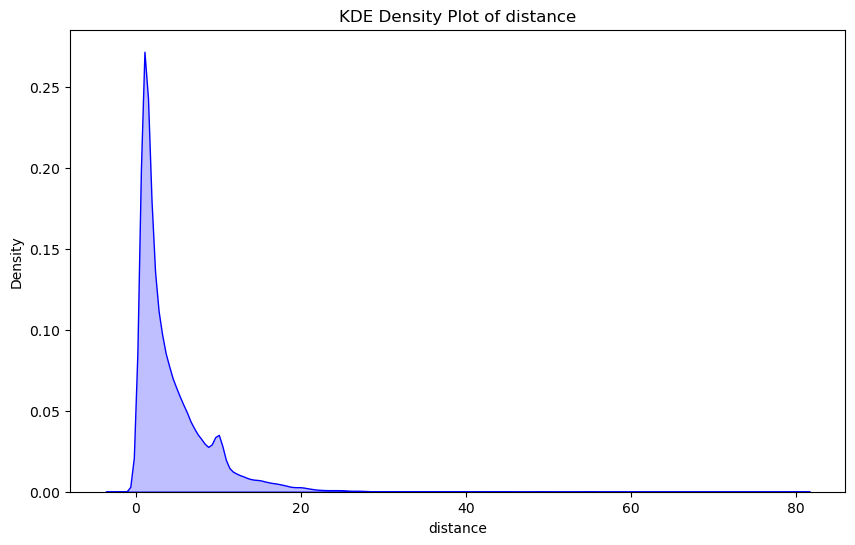

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(df.distance, fill=True, color='blue')
plt.title('KDE Density Plot of distance')
plt.xlabel('distance')
plt.ylabel('Density')
plt.show()

In [24]:
(
    df.query('100 >= yards_to_goal > 90').first_down.value_counts(normalize=True),
    df.query('90 >= yards_to_goal > 80').first_down.value_counts(normalize=True),
    df.query('80 >= yards_to_goal > 60').first_down.value_counts(normalize=True),
    df.query('60 >= yards_to_goal > 40').first_down.value_counts(normalize=True),
    df.query('40 >= yards_to_goal > 20').first_down.value_counts(normalize=True),
    df.query('20 >= yards_to_goal > 10').first_down.value_counts(normalize=True),
    df.query('10 >= yards_to_goal > 0').first_down.value_counts(normalize=True)
)

(first_down
 0    0.75
 1    0.25
 Name: proportion, dtype: float64,
 first_down
 0    0.65651
 1    0.34349
 Name: proportion, dtype: float64,
 first_down
 1    0.546421
 0    0.453579
 Name: proportion, dtype: float64,
 first_down
 1    0.545557
 0    0.454443
 Name: proportion, dtype: float64,
 first_down
 0    0.500701
 1    0.499299
 Name: proportion, dtype: float64,
 first_down
 0    0.501924
 1    0.498076
 Name: proportion, dtype: float64,
 first_down
 0    0.654417
 1    0.345583
 Name: proportion, dtype: float64)

## 5. Make the model

In [25]:
feature_names = [
    'distance',
    # 'score_diff',
    'diff_time_ratio',
    # 'pregame_elo_diff',
    # 'pct_game_played',
    'is_home_team',
    'precipitation', 
    'wind_speed', 
    'temperature', 
    'yards_to_goal', 
    'offense_strength', 
    'defense_strength'
]

data = df[['game_id','drive_id','play_id'] + feature_names + ['first_down']]

# Split into 80-20 train val set by game_id
game_ids = df.game_id.unique()
game_ids_train, game_ids_test = train_test_split(game_ids, test_size=0.2, random_state=42)

data_train = data[data.game_id.isin(game_ids_train)]
data_test = data[data.game_id.isin(game_ids_test)].drop(columns=['drive_id','play_id'])

In [26]:
data.isna().sum()

game_id             0
drive_id            0
play_id             0
distance            0
diff_time_ratio     0
is_home_team        0
precipitation       0
wind_speed          0
temperature         0
yards_to_goal       0
offense_strength    0
defense_strength    0
first_down          0
dtype: int64

In [27]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

# Set verbosity and random seed
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 2
np.random.seed(SEED)

# Prepare features and monotonic constraints
feature_names = data_train.drop(columns=['game_id','drive_id','play_id','first_down']).columns.tolist()
monotonic_constraints_map = {
    "score_diff": 1,
    "diff_time_ratio": 1,
    "pregame_elo_diff": 1,
    "is_home_team": 1,
    "precipitation": -1,
    "wind_speed": -1,
    "distance": -1,
    "offense_strength": 1,
    "defense_strength": -1,
}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])

# Only keep one play per drive
train_data = data_train.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_data = train_data.drop_duplicates(subset=['game_id', 'drive_id'], keep='first')

# Split into train-val set by game_id
game_ids_train, game_ids_valid = train_test_split(
    train_data.game_id.unique(), 
    test_size=0.2, 
    random_state=SEED
)
train = train_data[train_data.game_id.isin(game_ids_train)]
valid = train_data[train_data.game_id.isin(game_ids_valid)]

# Prepare data for XGBoost
train_x = train.drop(columns=['game_id', 'drive_id', 'play_id', 'first_down'])
train_y = train['first_down']
valid_x = valid.drop(columns=['game_id', 'drive_id', 'play_id', 'first_down'])
valid_y = valid['first_down']

dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

# Objective function for Optuna
def objective(trial):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "monotone_constraints": monotonic_constraints,
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    preds = bst.predict(dvalid)
    return log_loss(valid_y, preds)

# Run optimization
study = optuna.create_study(
    study_name="conversion_probability_hyperopt", 
    direction="minimize", 
    load_if_exists=True
)
study.optimize(objective, n_trials=50)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'monotone_constraints': monotonic_constraints,
    'eval_metric': 'logloss',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)

# train log loss
train_preds = final_model.predict(dtrain)
train_log_loss = log_loss(train_y, train_preds)
print(f'Train Log Loss: {train_log_loss:0.3f}')

# validation log loss
valid_preds = final_model.predict(dvalid)
valid_log_loss = log_loss(valid_y, valid_preds)
print(f'Validation Log Loss: {valid_log_loss:0.3f}')

# test log loss
test_x = data_test.drop(columns=['game_id', 'first_down'])
test_y = data_test['first_down']
dtest = xgb.DMatrix(test_x, label=test_y)
test_preds = final_model.predict(dtest)
test_log_loss = log_loss(test_y, test_preds)
print(f'Test Log Loss: {test_log_loss:0.3f}')

Train Log Loss: 0.613
Validation Log Loss: 0.612
Test Log Loss: 0.620


1. all features
Train Log Loss: 0.605
Validation Log Loss: 0.614
Test Log Loss: 0.623

2. without pregame elo diff and pct game played
Train Log Loss: 0.610
Validation Log Loss: 0.615
Test Log Loss: 0.625

3. same as 2 but with diff_time_ration instead of score_diff
Train Log Loss: 0.609
Validation Log Loss: 0.616
Test Log Loss: 0.624


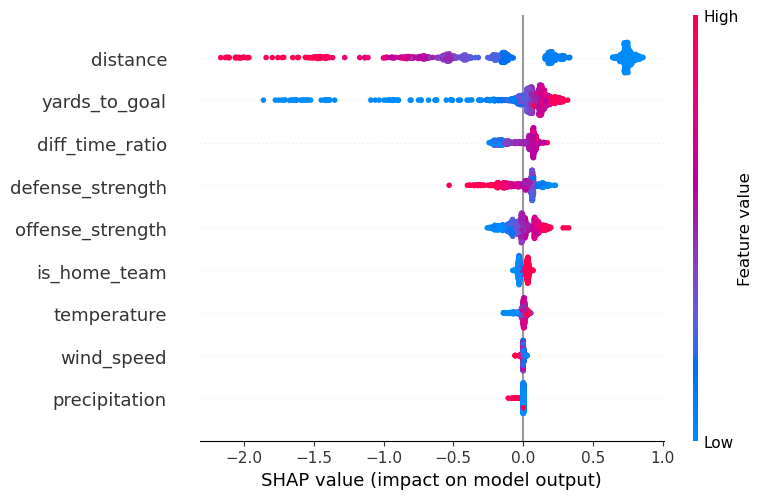

In [28]:
import shap
background = train[feature_names].head(1000)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(background)
shap.summary_plot(shap_values, 
                 background, 
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

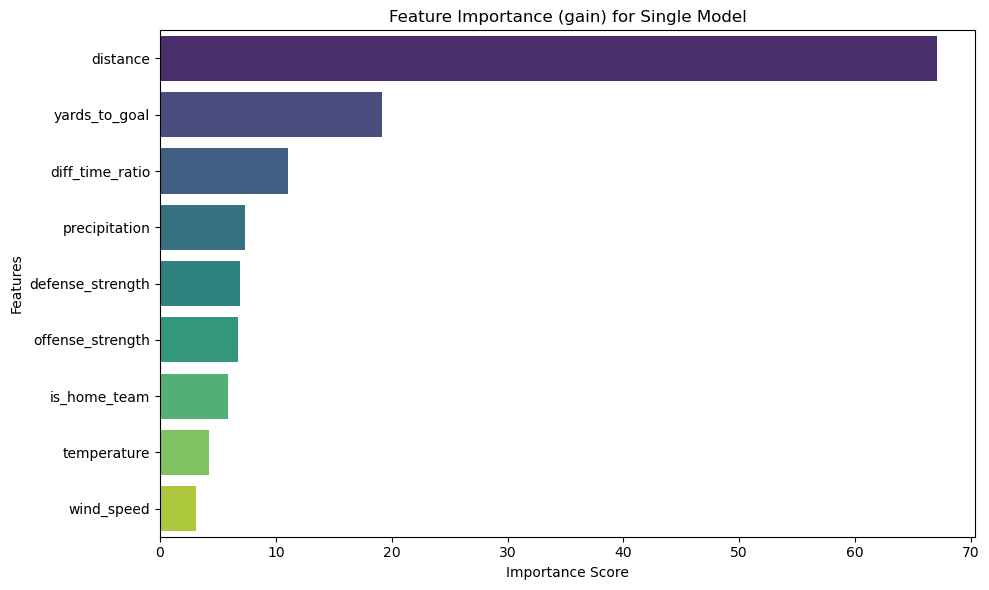

In [29]:
importance_type = "gain"  # Options: "gain", "weight", "cover"

# Get feature importance for a single model
importance = final_model.get_score(importance_type=importance_type)

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df, 
    palette="viridis", 
    hue="Feature", 
    dodge=False
)
plt.title(f"Feature Importance ({importance_type}) for Single Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [30]:
# predict conversion_proba for all plays
df['conversion_proba'] = final_model.predict(xgb.DMatrix(df[feature_names]))

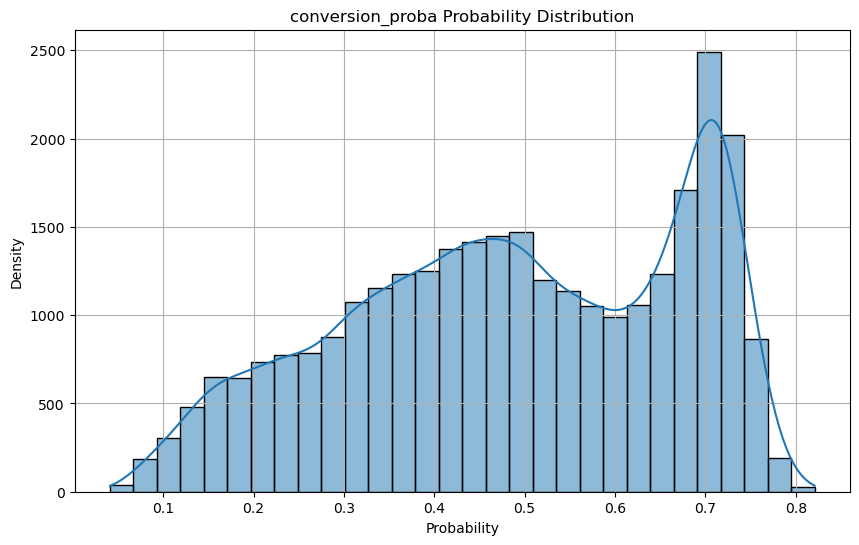

In [31]:
# plot win probability
def plot_wp(df, col='conversion_proba'):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.grid()
    plt.show()
plot_wp(df, col='conversion_proba')

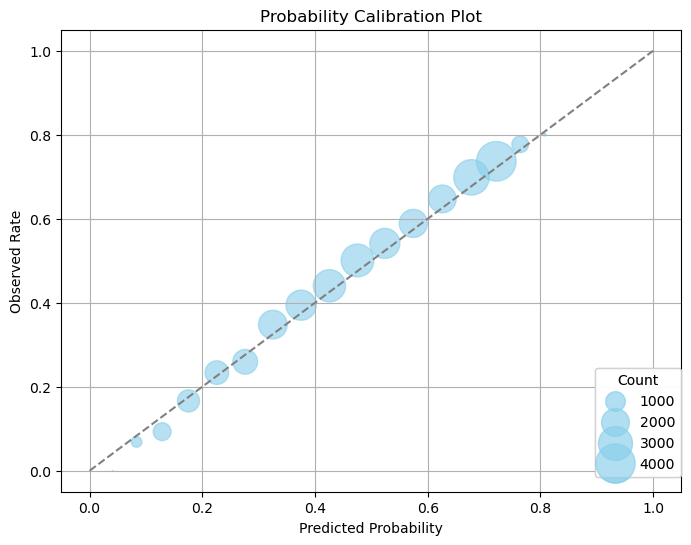

In [32]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.02):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        calibration['predicted_proba'], 
        calibration['actual_proba'], 
        s=calibration['count'] * scale,
        alpha=0.6, 
        label='Calibration Curve',
        color='skyblue',
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()

    # Add legend for dot size reference
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, num=4, func=lambda x: x / scale,
                                              color='skyblue')
    labels = [int(re.search(r'\{(\d+)\}', value).group(1)) for value in labels]
    legend = plt.legend(handles, labels, title="Count", loc="center left", bbox_to_anchor=(.85, 0.15))
    plt.gca().add_artist(legend)

    plt.show()

plot_calibration(df, proba_col='conversion_proba', actual_col='first_down', bins=20, scale=.2)

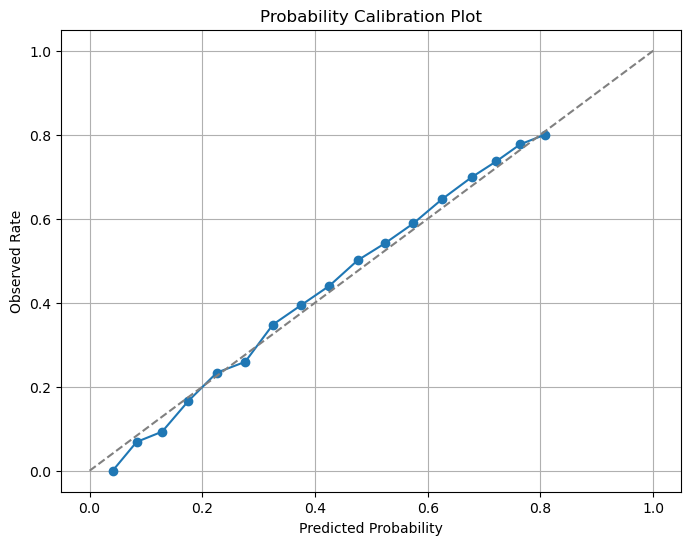

In [33]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid()
    plt.show()

plot_calibration(df, proba_col='conversion_proba', actual_col='first_down', bins=20)

In [34]:
df[feature_names + ['conversion_proba','first_down']].query('distance <= 3 and yards_to_goal > 5').sort_values(by='conversion_proba', ascending=True).head(20)

,distance,diff_time_ratio,is_home_team,precipitation,wind_speed,temperature,yards_to_goal,offense_strength,defense_strength,conversion_proba,first_down
20409,3,-496.083699,-1,0.000,8.1,39.6,8,-0.088329,0.256863,0.256898,0
11722,3,-2090.913517,-1,0.000,7.0,91.0,28,-0.126891,0.307214,0.273224,1
27880,3,-539.195381,-1,0.000,7.0,66.6,12,-0.020575,0.325383,0.287344,0
14580,3,-300.671336,-1,0.000,22.6,83.8,34,-0.256879,0.228891,0.298048,1
6424,3,-566.049423,-1,0.000,8.1,35.1,13,-0.153489,0.089361,0.300903,0
7338,3,-312.448289,-1,0.000,5.8,84.0,26,-0.214976,0.286138,0.302702,0
8081,3,-445.159057,-1,0.000,12.7,50.0,30,-0.039517,0.352840,0.304702,0
26799,3,-336.343302,0,0.000,0.0,70.0,38,-0.054786,0.331494,0.306638,0
2698,3,-1118.554500,1,0.000,11.4,75.0,6,-0.044829,0.063974,0.307810,1
21075,3,-509.771454,-1,0.000,11.4,80.4,43,-0.035433,0.391185,0.310489,1


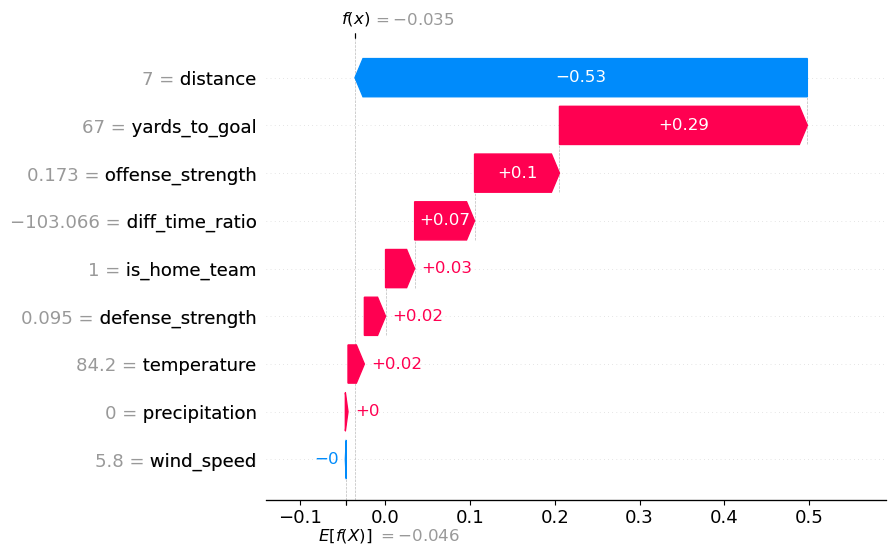

In [35]:
idx = 2935

game_data = data[data.index == idx].drop(columns=['game_id', 'drive_id', 'play_id', 'first_down']).head(1)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(game_data)
shap_values_explained = shap.Explanation(values=shap_values, 
                                         base_values=explainer.expected_value, 
                                         data=game_data, 
                                         feature_names=game_data.columns)

shap.plots.waterfall(shap_values_explained[0])
plt.show()

In [36]:
model_dir = join('..', '..', 'inference', 'models', 'fourth_down')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"xgb_classifier.json")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../../inference/models/fourth_down' folder.
